### Import Libraries

In [1]:
# Bibliotecas RAPIDS (GPU)
import cupy as cp
import cudf
from cuml.preprocessing import StandardScaler as cumlStandardScaler
from cuml.neighbors import KNeighborsClassifier
from cuml.metrics import accuracy_score as cuml_accuracy_score
from cuml.metrics import confusion_matrix as cuml_confusion_matrix

# Bibliotecas Scikit-learn (CPU)
import numpy as np
import pandas as pd
from sklearn.preprocessing import LabelEncoder, StandardScaler as sklearnStandardScaler
from sklearn.model_selection import StratifiedKFold
from sklearn.svm import SVC
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix
from sklearn.pipeline import Pipeline as sklearnPipeline

# Bibliotecas de Extração e Plotagem
import librosa
from scipy import stats
import matplotlib.pyplot as plt
import seaborn as sns
import os
from tqdm import tqdm
import utils

### Audio Preprocessing

In [2]:
# --- Configuração ---
METADATA_DIR = '../fma_metadata'
AUDIO_DIR_GENRES = '../fma_datasets/fma_small_genres'
FEATURE_FILE_X = '../preprocessed_features/fma_small_windowed_X_518.npy'
FEATURE_FILE_y = '../preprocessed_features/fma_small_windowed_y_518.npy'

# --- Carregar Metadados ---
tracks = utils.load(f'{METADATA_DIR}/tracks.csv')

small_mask = tracks[('set', 'subset')] == 'small'
y_all_labels_pd = tracks.loc[small_mask, ('track', 'genre_top')] # Em pandas
splits_pd = tracks.loc[small_mask, ('set', 'split')] # Em pandas

# --- Codificar os Gêneros (Labels) usando Sklearn ---
label_encoder = LabelEncoder()
# fit_transform em um pandas Series retorna um array numpy
y_all_encoded_np = label_encoder.fit_transform(y_all_labels_pd).astype(np.int32) # Converte para int32

# Criar um DataFrame pandas para referência durante a extração
track_metadata = pd.DataFrame({
    'genre_top': y_all_labels_pd,
    'genre_encoded': y_all_encoded_np,
    'split': splits_pd
}, index=y_all_labels_pd.index)

# Obter nomes das classes para posterior plotagem
class_names = label_encoder.classes_

print(f"Metadados carregados para {track_metadata.shape[0]} faixas 'small'.")
print(f"Gêneros: {class_names}")

Metadados carregados para 8000 faixas 'small'.
Gêneros: ['Electronic' 'Experimental' 'Folk' 'Hip-Hop' 'Instrumental'
 'International' 'Pop' 'Rock']


In [3]:
def calculate_stats(features_matrix):
    """
    Calcula as 3 estatísticas (mean, std, mode) 
    exigidas pelo features.py.
    """
    result = []
    
    # Garantir que a matriz não esteja vazia
    if features_matrix.size == 0:
        # Retorna um vetor de zeros com o tamanho esperado (N_features * 7 stats)
        # O chamador precisa saber o N_features esperado
        return None 

    # 1. mean
    result.extend(np.mean(features_matrix, axis=1))
    # 2. std
    result.extend(np.std(features_matrix, axis=1))
    # 3. skew
    result.extend(stats.skew(features_matrix, axis=1))
    # 4. kurtosis
    result.extend(stats.kurtosis(features_matrix, axis=1))
    # 5. median
    result.extend(np.median(features_matrix, axis=1))
    # 6. min
    result.extend(np.min(features_matrix, axis=1))
    # 7. max
    result.extend(np.max(features_matrix, axis=1))
    
    return np.array(result)

def calculate_stats_from_mfccs(features_matrix):
    """
    Calcula as 3 estatísticas (mean, std, moda) 
    exigidas pelo features.py.
    """
    result = []
    
    # Garantir que a matriz não esteja vazia
    if features_matrix.size == 0:
        # Retorna um vetor de zeros com o tamanho esperado (N_features * 3 stats)
        # O chamador precisa saber o N_features esperado
        return None 

    # 1. mean
    result.extend(np.mean(features_matrix, axis=1))
    # 2. std
    result.extend(np.std(features_matrix, axis=1))
    # 3. skew
    result.extend(stats.skew(features_matrix, axis=1))

    return np.array(result)


def extract_features_windowed_full(file_path, window_size_sec=3, sr=22050):
    """
    Extrai o conjunto completo de 518 features para cada janela de 3s.
    Esta função é uma adaptação de 'compute_features' de features.py.
    """
    
    all_window_features = []
    
    # Parâmetros do librosa (como em features.py e baselines.ipynb)
    N_FFT = 2048
    HOP_LENGTH = 512
    N_MFCC = 20
    N_CHROMA = 12
    N_CONTRAST = 7 # 6 bandas + 1 (em features.py é 7)
    N_TONNETZ = 6
    
    try:
        y, sr_loaded = librosa.load(file_path, mono=True, sr=sr, res_type='kaiser_fast')
        
        samples_per_window = window_size_sec * sr
        n_windows = int(np.floor(len(y) / samples_per_window))
        
        for w in range(n_windows):
            start = w * samples_per_window
            end = start + samples_per_window
            y_window = y[start:end]
            
            # STFT e CQT (bases para muitas features)
            #
            stft = np.abs(librosa.stft(y_window, n_fft=N_FFT, hop_length=HOP_LENGTH))
            cqt = np.abs(librosa.cqt(y_window, sr=sr, hop_length=HOP_LENGTH))
            
            window_vector = [] # O vetor final de 518 features para esta janela
            
            # 1. ZCR (1 * 7 = 7 features)
            #
            f = librosa.feature.zero_crossing_rate(y_window, frame_length=N_FFT, hop_length=HOP_LENGTH)
            window_vector.extend(calculate_stats(f))
            
            # 2. Chroma CQT (12 * 7 = 84 features)
            #
            f = librosa.feature.chroma_cqt(C=cqt, n_chroma=N_CHROMA)
            window_vector.extend(calculate_stats(f))

            # 3. Chroma CENS (12 * 7 = 84 features)
            #
            f = librosa.feature.chroma_cens(C=cqt, n_chroma=N_CHROMA)
            window_vector.extend(calculate_stats(f))
            
            # 4. Chroma STFT (12 * 7 = 84 features)
            #
            f = librosa.feature.chroma_stft(S=stft**2, n_chroma=N_CHROMA)
            window_vector.extend(calculate_stats(f))
            
            # 5. RMSE (1 * 7 = 7 features)
            #
            f = librosa.feature.rms(S=stft) # Nota: features.py usa 'rmse', mas 'rms' é a função atual
            window_vector.extend(calculate_stats(f))

            # 6. Spectral Centroid (1 * 7 = 7 features)
            #
            f = librosa.feature.spectral_centroid(S=stft)
            window_vector.extend(calculate_stats(f))

            # 7. Spectral Bandwidth (1 * 7 = 7 features)
            #
            f = librosa.feature.spectral_bandwidth(S=stft)
            window_vector.extend(calculate_stats(f))

            # 8. Spectral Contrast (7 * 7 = 49 features)
            #
            f = librosa.feature.spectral_contrast(S=stft, n_bands=N_CONTRAST - 1)
            window_vector.extend(calculate_stats(f))

            # 9. Spectral Rolloff (1 * 7 = 7 features)
            #
            f = librosa.feature.spectral_rolloff(S=stft)
            window_vector.extend(calculate_stats(f))
            
            # 10. MFCC (20 * 3 = 60 features)
            #
            mel = librosa.feature.melspectrogram(S=stft**2, sr=sr)
            f = librosa.feature.mfcc(S=librosa.power_to_db(mel), n_mfcc=N_MFCC)
            window_vector.extend(calculate_stats_from_mfccs(f))
            
            # 11. Tonnetz (6 * 7 = 42 features)
            #
            # (Calculado por último, pois pode depender do chroma_cens)
            f_chroma_cens = librosa.feature.chroma_cens(C=cqt, n_chroma=N_CHROMA) # Recalcula se necessário
            f = librosa.feature.tonnetz(y=librosa.effects.harmonic(y_window), sr=sr, chroma=f_chroma_cens)
            window_vector.extend(calculate_stats(f))
            
            # Adicionar o vetor completo (438 features)
            all_window_features.append(window_vector)
            
    except Exception as e:
        print(f"Erro ao processar {file_path}: {e}")
        
    return all_window_features

In [4]:
if not os.path.exists(FEATURE_FILE_X):
    print(f"Arquivos de features não encontrados. Iniciando extração (isso pode levar horas)...")
    
    all_features = []
    all_labels = []
    
    for track_id, row in tqdm(track_metadata.iterrows(), total=track_metadata.shape[0]):
        genre_top = row['genre_top']
        file_path = f"{AUDIO_DIR_GENRES}/{genre_top}/{track_id:06d}.mp3"
        
        if not os.path.exists(file_path):
            continue
            
        window_vectors = extract_features_windowed_full(file_path)
        
        for vec in window_vectors:
            if len(vec) == 518:
                all_features.append(vec)
                all_labels.append(row['genre_encoded']) # Já está como int32

    X_np = np.array(all_features)
    y_encoded_np = np.array(all_labels, dtype=np.int32) # Garante int32

    print(f"\nExtração concluída. Total de janelas: {X_np.shape[0]}. Features: {X_np.shape[1]}")
    print(f"Salvando features em {FEATURE_FILE_X}...")
    np.save(FEATURE_FILE_X, X_np)
    np.save(FEATURE_FILE_y, y_encoded_np)

else:
    print(f"Carregando features cacheadas de {FEATURE_FILE_X}...")
    X_np = np.load(FEATURE_FILE_X)
    y_encoded_np = np.load(FEATURE_FILE_y) # Já deve ser int32
    print("Features carregadas.")

# Lidando com NaNs ou Infs
X_np = np.nan_to_num(X_np, nan=0.0, posinf=0.0, neginf=0.0)

print(f"Total de amostras (janelas) para CV: {X_np.shape[0]}")
print(f"Tipo de dado das features (X): {X_np.dtype}")
print(f"Tipo de dado das labels (y): {y_encoded_np.dtype}")

Carregando features cacheadas de ../preprocessed_features/fma_small_windowed_X_518.npy...
Features carregadas.
Total de amostras (janelas) para CV: 75296
Tipo de dado das features (X): float64
Tipo de dado das labels (y): int64


### Treino dos Modelos


Iniciando CV 10-Fold para KNN (GPU)...

Iniciando CV 10-Fold para SVM (CPU)...

Iniciando CV 10-Fold para Random Forest (CPU)...

--- Treinamento e Avaliação de CV Concluídos ---

========= Resultados KNN (GPU) (10-Fold CV) - Janelas de 3s ==========
--- Acurácia ---
  Média        : 0.5056
  Desv. Padrão : 0.0044
--- Precisão (Macro) ---
  Média        : 0.5493
  Desv. Padrão : 0.0056
--- Recall (Macro) ---
  Média        : 0.5058
  Desv. Padrão : 0.0044
--- F1-Score (Macro) ---
  Média        : 0.4818
  Desv. Padrão : 0.0050

========= Resultados SVM (CPU) (10-Fold CV) - Janelas de 3s ==========
--- Acurácia ---
  Média        : 0.7183
  Desv. Padrão : 0.0054
--- Precisão (Macro) ---
  Média        : 0.7159
  Desv. Padrão : 0.0055
--- Recall (Macro) ---
  Média        : 0.7184
  Desv. Padrão : 0.0053
--- F1-Score (Macro) ---
  Média        : 0.7160
  Desv. Padrão : 0.0054

========= Resultados Random Forest (CPU) (10-Fold CV) - Janelas de 3s ==========
--- Acurácia ---
  Média      

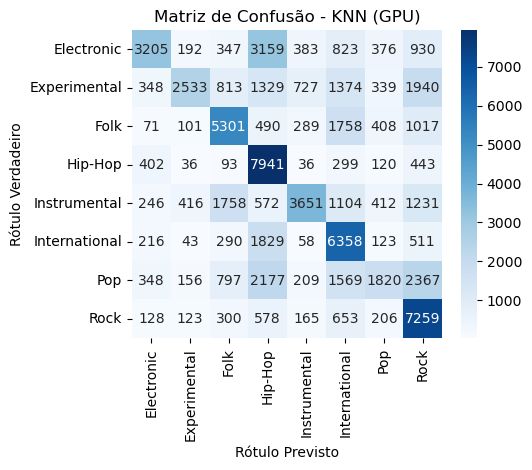

--- SVM (CPU) ---


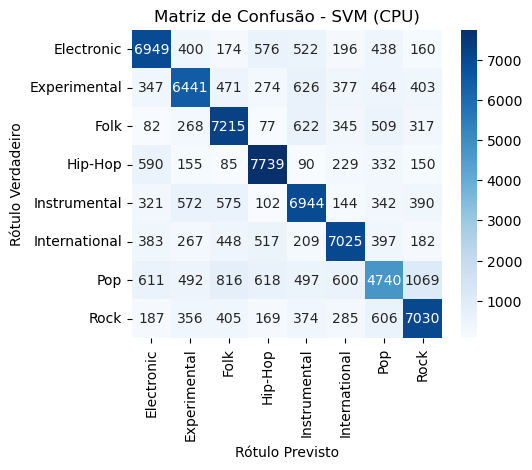

--- Random Forest (CPU) ---


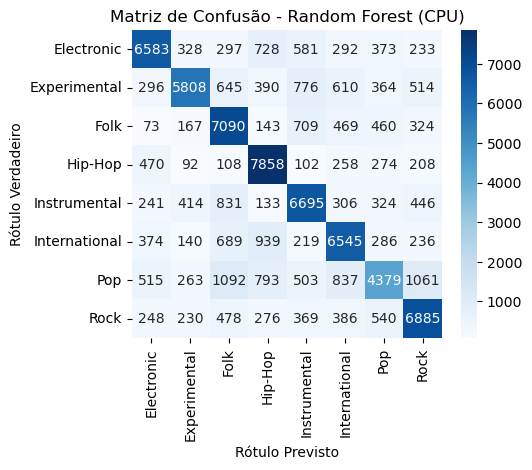

In [5]:
def calculate_metrics_from_confusion_matrix(cm):
    """
    Calcula Precisão, Recall e F1 (macro) a partir de uma matriz de confusão (numpy ou cupy).
    """
    # Converte para cupy array para cálculo rápido na GPU
    cm_cp = cp.asarray(cm) 
    epsilon = 1e-9
    tp = cp.diag(cm_cp)
    fp = cp.sum(cm_cp, axis=0) - tp
    fn = cp.sum(cm_cp, axis=1) - tp
    
    precision_per_class = tp / (tp + fp + epsilon)
    recall_per_class = tp / (tp + fn + epsilon)
    f1_per_class = 2 * (precision_per_class * recall_per_class) / (precision_per_class + recall_per_class + epsilon)
    
    # Retorna métricas como escalares cupy
    return cp.mean(precision_per_class), cp.mean(recall_per_class), cp.mean(f1_per_class)

# 1. Definir a Estratégia de CV (SKLEARN KFold)
n_splits = 10
# Usando kf do sklearn. `split` retornará índices numpy.
kf = StratifiedKFold(n_splits=n_splits, shuffle=True, random_state=42) 

# 2. Definir Modelos e Pipelines
# (Estes são os mesmos da tentativa anterior, híbridos GPU/CPU)

## Modelo KNN (GPU) - Usará scaler do cuML
model_knn = KNeighborsClassifier(n_neighbors=85)
scaler_knn = cumlStandardScaler() # Scaler do cuML

## Pipeline para SVM (CPU) - Pipeline do Sklearn
pipe_svm = sklearnPipeline([
    ('scaler', sklearnStandardScaler()),
    ('svm', SVC(decision_function_shape="ovo", kernel='rbf', C=1.0, gamma='scale')) 
])

## Pipeline para Random Forest (CPU) - Pipeline do Sklearn
pipe_rf = sklearnPipeline([
    ('scaler', sklearnStandardScaler()),
    ('rf', RandomForestClassifier(n_estimators=100, max_depth=100, criterion="gini", random_state=42, n_jobs=-1))
])

models = {
    "KNN (GPU)": model_knn,
    "SVM (CPU)": pipe_svm,
    "Random Forest (CPU)": pipe_rf
}

cv_scores = {}
out_of_fold_preds = {}

# 3. Executar a Validação Cruzada (Híbrida)
for model_name, model in models.items():
    print(f"\nIniciando CV {n_splits}-Fold para {model_name}...")
    
    fold_scores_acc = []
    fold_scores_precision = []
    fold_scores_recall = []
    fold_scores_f1 = []
    
    all_preds_for_model = []
    all_true_for_model = []

    # kf.split() agora retorna índices NumPy (train_idx, test_idx)
    for fold, (train_idx, test_idx) in enumerate(kf.split(X_np, y_encoded_np)):
        
        # Índices são numpy, indexação direta de arrays numpy
        X_train_np_fold = X_np[train_idx]
        y_train_np_fold = y_encoded_np[train_idx]
        X_test_np_fold = X_np[test_idx]
        y_true_np_fold = y_encoded_np[test_idx]
        
        if "GPU" in model_name:
            # --- Bloco GPU (cuML) ---
            # Move os dados do fold atual para a VRAM
            X_train_cp = cp.array(X_train_np_fold)
            y_train_cp = cp.array(y_train_np_fold, dtype=cp.int32) 
            X_test_cp = cp.array(X_test_np_fold)
            y_true_cp = cp.array(y_true_np_fold, dtype=cp.int32) 

            # Normaliza na GPU
            scaler_knn.fit(X_train_cp)
            X_train_scaled_cp = scaler_knn.transform(X_train_cp)
            X_test_scaled_cp = scaler_knn.transform(X_test_cp)
            
            model.fit(X_train_scaled_cp, y_train_cp)
            y_pred_cp = model.predict(X_test_scaled_cp) 
            
            # Métricas na GPU
            y_true = y_true_cp 
            y_pred = y_pred_cp 
            acc = cuml_accuracy_score(y_true, y_pred)
            cm_fold = cuml_confusion_matrix(y_true, y_pred) # Matriz cuPy
            
            # Limpa memória VRAM
            del X_train_cp, y_train_cp, X_test_cp, y_true_cp, X_train_scaled_cp, X_test_scaled_cp

        else:
            # --- Bloco CPU (Sklearn) ---
            # 'model' aqui é um pipeline do sklearn
            model.fit(X_train_np_fold, y_train_np_fold)
            y_pred_np = model.predict(X_test_np_fold)
            
            # Métricas na CPU
            y_true = y_true_np_fold
            y_pred = y_pred_np
            acc = accuracy_score(y_true, y_pred)
            cm_fold = confusion_matrix(y_true, y_pred) # Matriz NumPy
        
        # --- Cálculo de Métricas (CPU ou GPU) ---
        # Acurácia (acc) já é um escalar (seja de cuml ou sklearn)
        fold_scores_acc.append(acc) 
        
        # Passa a matriz (seja cupy ou numpy) para a função
        macro_p, macro_r, macro_f1 = calculate_metrics_from_confusion_matrix(cm_fold)
        
        # movemos para cpu (numpy) para armazenar na lista python
        fold_scores_precision.append(cp.asnumpy(macro_p))
        fold_scores_recall.append(cp.asnumpy(macro_r))
        fold_scores_f1.append(cp.asnumpy(macro_f1))
        
        # Se os dados já são numpy (do else), não precisa converter
        if isinstance(y_pred, cp.ndarray):
            all_preds_for_model.append(cp.asnumpy(y_pred))
            all_true_for_model.append(cp.asnumpy(y_true))
        else:
            all_preds_for_model.append(y_pred)
            all_true_for_model.append(y_true)

    # Guardar os scores (em arrays numpy)
    cv_scores[model_name] = {
        'Acurácia': np.array(fold_scores_acc),
        'Precisão (Macro)': np.array(fold_scores_precision),
        'Recall (Macro)': np.array(fold_scores_recall),
        'F1-Score (Macro)': np.array(fold_scores_f1)
    }
    
    out_of_fold_preds[model_name] = {
        'y_true': np.concatenate(all_true_for_model),
        'y_pred': np.concatenate(all_preds_for_model)
    }

print("\n--- Treinamento e Avaliação de CV Concluídos ---")

# 4. Analisar Resultados (Relatório de Métricas)
for model_name, metrics in cv_scores.items():
    print(f"\n========= Resultados {model_name} ({n_splits}-Fold CV) - Janelas de 3s ==========")
    
    for metric_name, scores_cpu in metrics.items():
        print(f"--- {metric_name} ---")
        print(f"  Média        : {scores_cpu.mean():.4f}")
        print(f"  Desv. Padrão : {scores_cpu.std():.4f}")

# 5. Análise (Matrizes de Confusão)
print("\n\n========= Matrizes de Confusão (Agregadas da CV) - Janelas de 3s ==========")

for model_name, results in out_of_fold_preds.items():
    print(f"--- {model_name} ---")
    
    # Matriz agora está em numpy (cm_cpu)
    cm_cpu = confusion_matrix(results['y_true'], results['y_pred'])
    
    plt.figure(figsize=(5, 4))
    sns.heatmap(cm_cpu, annot=True, fmt='d', cmap='Blues',
                xticklabels=class_names, yticklabels=class_names)
    plt.title(f'Matriz de Confusão - {model_name}')
    plt.ylabel('Rótulo Verdadeiro')
    plt.xlabel('Rótulo Previsto')
    plt.show()